**TP n°1**
Notions abordées:

En partie I:
- Apprentissage d'un perceptron par descente de gradient stochastique.
- Perceptron à plusieurs couches
- Fonction de coût adaptée aux tâches de classification.

En partie II:
- Autres briques de bases des réseaux profond: couches de convolutions et non-linéarités.
- Analyse d'un réseau profond standard  entraîné sur imagenet.

En partie III:
- Entraînement d'un CNN sur MNIST. Comparaison avec un perceptron multicouches.
- Méthodes d'initialisation, méthodes de régularisation.

En partie IV:
- Apprentissage sur une carte graphique
- Amélioration de la descente de gradient: SGD avec inertie (*momentum*) et diminution progressive du taux d'apprentissage (*scheduler*).
- Transfer learning: fine tuning et freezing.



Durée : 4 h

**Partie I**

Cette partie introduit les réseaux de neurones à travers une présentation du perceptron. C'est aussi l'occasion de vous familiariser avec les commandes pytorch. Pytorch est l'une des trois librairies les plus utilisées pour le deep learning avec Keras et TensorFlow.

Le "deep learning", c'est, par définition, l'apprentissage de réseaux de neurones "profonds" par descente de gradient stochastique. Par profond, on entend: constitués d'un succession de "couches" de neurones.

Sous pytorch, les briques de base qui permettent de construire ces couches sont codées dans le module torch.nn.

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn

**A.** Dans un premier temps, nous revenons sur le perceptron.
Pour présenter un apprentissage par descente de gradient stochastique, 
nous allons aborder un problème de classification binaire simple. 

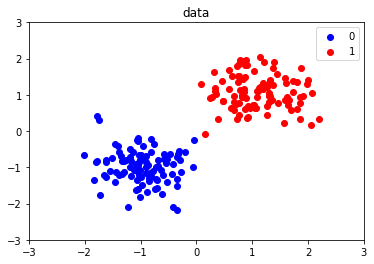

In [ ]:
#Les données à séparer:
n = 100
std = 0.5

#échantillon 1:
mean0 = torch.tensor((-1.,-1.))
ech0 = mean0 + std*torch.randn(n,2) 

#échantillon 2:
mean1 = torch.tensor((1.,1.))
ech1 = mean1 + std*torch.randn(n,2) 

echs = [ech0, ech1]


#scatter plot:
fig, ax = plt.subplots()
ax.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b','r']
labels = ['0','1']

for i,ech in enumerate(echs):
    x,y = ech.numpy()[:,0], ech.numpy()[:,1]
    ax.scatter(x,y, color = colors[i] )

plt.legend(labels)

Un perceptron simple (un seul neurone) comporte deux parties. Une partie linéaire, qui contient un produit scalaire et un "biais" ($b$) et une partie non linéaire, la fonction d'activation ($\mathcal{A}$):
\begin{equation*}
 f(x; \omega,b) = \mathcal{A}({\sum} \omega_i x_i  + b )  \tag{1}
\end{equation*}

La classe P1 ci-dessous code pour des perceptrons définis sur $\mathbb{R}^2$  et dont la fonction d'activation est une sigmoïde:
\begin{equation*}
\mathcal{A}(y) = \dfrac{1}{1+e^{-y}}
\end{equation*}
La fonction sigmoïde est à valeur dans [0,1]. On peut donc interpréter la sortie du neurone comme la probabilité d'appartenance à la première des deux classes. Dans la classe *P1*, le neurone renvoie d'ailleurs un vecteur de "probabilités":

In [ ]:
class P1(nn.Module):

    def __init__(self):
        super(P1, self).__init__()
        self.fc = nn.Linear(2,1)         

    def forward(self, x):
      
        #produit scalaire et biais
        x = self.fc(x)

        #activation                   
        x = x.sigmoid()

        #vecteur de "probabilités" (cat: concaténation)
        x = torch.cat((x,1-x), dim = 1)  
        return x

model = P1()
print(model)

Dans la cellule suivante, on donne les commandes de base pour accéder aux poids d'une instance de *P1*.

In [ ]:
#initialisation (fantaisiste) des poids:
model.fc.weight[0,0].data.fill_(-0.1)
model.fc.weight[0,1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

#récupération des poids:
fc = model.fc
weights = fc.weight.data.squeeze(dim=0)
bias = fc.bias.data

print(weights)
print(bias)

tensor([-0.1000,  0.5000])
tensor([-1.])


**Exercice**: Vérifier sur un exemple l'égalité $f_c(x) = \sum \omega_i x_i  + b$ 

Pour compléter la définition du perceptron, il faut une règle de décision. Cette règle est naturelle: pour $f(x ; \omega,b) = (p_0, p_1)$, on choisit la classe $0$ ssi $p_0 > p_1$.  \\

On peut tracer la frontière qui délimite les zones de décision du modèle. Donner son équation sous la forme $x_1 = \alpha x_0 + \beta$ où $\alpha$ et $\beta$ dépendent de $\omega$ et $b$. 
Compléter le code ci-dessous pour la tracer.

In [ ]:
#Tracé de la droite séparatrice:
def traceFrontiere(weights, bias, ax, interval = [-10,10], color = 'black'):
  
    x0 = np.arange(interval[0],interval[1],0.01)

    x1 = [...]

    ax.plot(x0,x1,color = color)
    
    
traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig

Pour apprendre au perceptron à séparer correctement les classes, nous allons utiliser une descente de gradient stochastique par mini-batches. 
Pour ça, nous avons besoin de pouvoir présenter au modèle des couples (*entrée*, *cible*) dans un ordre **aléatoire**.
Dans pytorch, cette sélection se fait grâce à deux objets: 
- Une classe *Dataset*
- Une classe *Dataloader* 


In [ ]:
from torch.utils.data import Dataset, DataLoader

Un *Dataset* pytorch contient une méthode d'accès aux données. La classe suivante donne un exemple rudimentaire. \\
Plus loin, nous intégrerons à nos datasets des étapes de chargement, de normalisation et d'augmentation de données. 

In [ ]:
class FirstDataset(Dataset):
    def __init__(self, inputs, targets):  
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):     #idx est un indice appelé par le loader
        x = self.inputs[idx,:]
        t = self.targets[idx]           
        return x, t                 #couple (input, target)

inputs_train = torch.cat(echs, dim=0)
targets_train = torch.cat((torch.zeros(n),torch.ones(n)), dim = 0).long() 
ds0 = FirstDataset(inputs_train, targets_train)

Un loader est un itérable python (comme les listes, les dictionnaires, etc) qu'on paramètre par la taille des batches et la méthode de sélection des données (avec ou sans remise, pondération, etc). En particulier, avec l'option shuffle = True, le tirage se fait sans remise, jusqu'à épuisement du jeu de données:


In [ ]:
loader = DataLoader(ds0,batch_size = 10, shuffle = True)

Sur la figure suivante, on représente un premier batch de points tirés au hasard. A chaque exécution de la fenêtre qui suit, un nouveau batch de points est tiré jusqu'à épuisement.

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.axis([-3, 3, -3, 3])

#premier batch de dix points
inputs, targets = next(iter(loader))
x,y = inputs.numpy()[:,0], inputs.numpy()[:,1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x,y, color = cs )

In [ ]:
#Parcours du jeu de données
inputs, targets = next(iter(loader))
x,y = inputs.numpy()[:,0], inputs.numpy()[:,1]
cs = [colors[targets[i]] for i in range(len(targets))]
ax2.scatter(x,y, color = cs )
fig2

Pour chaque batch mis à disposition, on calcule l'erreur modèle à l'aide d'une fonction de coût (loss function). Cette fonction de coût pénalise les écarts entre les sorties du réseau (ici $(p_0,p_1)$) et la cible (ici, une classe $c \in \{ 0 ; 1 \}$).  
En classification on utilise en général la log vraisemblance (*Negative Log Likelihood*). Pour un point du batch, elle est définie par:

$\mathcal{L}((p_0,p_1), c)  = - ln(p_c)$   

Cette quantité est moyennée sur chaque batch.


In [ ]:
def loss_fn(outputs, targets, show = False ):

  # tous les -log(p)
  outputs = - torch.log(outputs)
  # tous les -log(pc)
  tensor_of_losses = torch.gather(outputs, 1, targets.unsqueeze(dim=1))
  # moyenne des -log(pc)
  loss = tensor_of_losses.mean()

  if show:
    print(outputs)
    print(targets)
    print(tensor_of_losses)  

  return loss

In [ ]:
# Exemple : 
inputs, targets = next(iter(loader))
l = loss_fn(model(inputs), targets, show = True)

print(l)

Pour chaque batch, on doit calculer les dérivées $\dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}}$ où $\mathcal{L_{batch}}$ est la moyenne de la fonction de coût sur le batch. \\

Pytorch garde en mémoire chacune des opérations effectuées avec les poids pour pouvoir appliquer les régles de dérivation usuelles. Ce calcul est lancé avec la méthode *.backward*. Les dérivées sont stockés avec les poids,
et sont accessibles avec *.grad*. 

In [ ]:
w = model.fc.weight #[0,0]
print('avant backward:' + str(w.grad))

l.backward()

print('après backward:' + str(w.grad))

Dernière étape: la mise à jour des poids. \\
Pour ça, un grand nombre de méthodes sont disponibles. 
On précise la méthode choisie à travers l'objet pytorch "optimizer". \\
La plus simple s'écrit: \\
\begin{equation*}
w_i : = w_i - lr \times \dfrac{\partial \mathcal{L_{batch}}}{\partial{\omega_i}} \tag{2} 
\end{equation*}

 Le learning rate ($lr$) contrôle l'amplitude des incréments. 

In [ ]:
lr = 0.1

#Deux méthodes de descente très utilisées:
optimizer = torch.optim.SGD(model.parameters(), lr = lr)            #correspond à l'équation (2)
#optimizer = torch.optim.Adam(model.parameters(), lr = lr)

Dans la cellule suivante, on entraîne le perceptron. A chaque nouvelle éxécution, le jeu de données est parcouru deux fois (deux "époques").

In [ ]:
for epoch in range(2):                   
    print(epoch)

    #parcours aléatoire du jeu de données
    for x, label in loader:               
        
        #remise à zéro des gradients 
        optimizer.zero_grad()             
        
        #calcul de (p0,p1)
        output = model(x)                 
        
        #calcul de l'erreur
        l = loss_fn(output, label)  

        #"calcul" des gradients
        l.backward()                      
        
        #mise à jour des poids
        optimizer.step()                  

    
    #Tracé de l'hyperplan
    fc = model.fc
    weights = fc.weight.data.squeeze(dim=0)
    bias = fc.bias.data
    traceFrontiere(weights.numpy(), bias.numpy(), ax)

fig

**Exercice**: compléter le code suivant pour tracer les gradients dans l'espace des poids $\omega_0, \omega_1$.

In [ ]:
#initialisation des poids:
model.fc.weight[0,0].data.fill_(-0.1)
model.fc.weight[0,1].data.fill_(0.5)
model.fc.bias.data.fill_(-1)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111)
ax3.axis([-1.5, 0, -1, 0.6])


loader = DataLoader(ds0,batch_size = 10,shuffle = True)
lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = lr)  

for epoch in range(5):
    for x, label in loader:      
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        
        #tracé des vecteurs:
        weights = ...
           
        ax3.scatter(...)        
        ax3.arrow(...)
        optimizer.step()


**Exercice:** Déterminer la justesse (*accuracy*) du classifieur sur le set d'entraînement.

In [ ]:
#%justesse sur le set d'entraînement:  

**Remarque:** 
Un modèle de la classe *P1* correspond à une classe de modèle statistique largment utilisé avec des prédicteurs de petites dimensions: la [régression logistique](http://wikistat.fr/pdf/st-m-modlin-reglog.pdf).

Ce modèle est utilisé pour **expliquer et prédire** la valeur d'une variable qualitative binaire. 

Notons par exemple $Z$ une variable aléatoire à valeurs dans $\{c_1, c_2\}$. 
La régression logistique par rapport au prédicteur $X = (X_1, X_2, ...)$ s'écrit :  

$$ ℙ(Z = c_1 | X )  = \sigma (\sum \omega_i X_i + b ) $$

Où $\sigma$ est la fonction sigmoïde. Dans le cadre d'une régression logistique, les poids $\omega_i$ sont obtenus par **maximum de vraisemblance**.

**B.** Maintenant, on se pose la question de la séparation d'ensembles de points plus complexes:

In [ ]:
n = 100
std = 0.5
#échantillon 0:
meana = torch.tensor((-1.,-1.))
echa = meana + std*torch.randn(n,2) 
meanb = torch.tensor((1.,1.))
echb = meanb + std*torch.randn(n,2) 

ech0 = torch.cat([echa,echb])


#échantillon 1:
meanc = torch.tensor((1.,-1.))
echc = meanc + std*torch.randn(n,2) 
meand = torch.tensor((-1.,1.))
echd = meand + std*torch.randn(n,2) 

ech1 = torch.cat([echc,echd])

echs= [ech0,ech1]

#scatter plot:

plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b','r']
labels = ['0','1']

for i,ech in enumerate(echs):
    x,y = ech.numpy()[:,0], ech.numpy()[:,1]
    plt.scatter(x,y, color = colors[i] )

plt.legend(labels)

**Exercice:** Quel est, approximativement, la meilleure justesse atteignable avec un modèle de la classe *P1* ? 
Compléter la classe *P3* et entraîner un modèle pour obtenir une justesse d'au moins 90% sur le jeu d'entraînement. \\
Pourquoi le score au bout de 50 époques varie-t-il autant à chaque nouvel entraînement? \\
Est-il possible, avec une autre classe de modèle, d'obtenir une justesse de 100% ?

In [ ]:
class P3(nn.Module):

    def __init__(self):
        super(P3, self).__init__()
        self.fc1 = nn.Linear(2,2)     #première couche: 2 neurones
        self.fc2 = nn.Linear(2,1)     #deuxième couche: 1 neurone

        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)

        [...]

        x = torch.cat((x,1-x), dim = 1)  #output de somme 1
        return x

**C.** Voyons maintenant comment généraliser l'approche à plusieurs classes:

In [ ]:
n = 100
std = 0.5
#échantillon 0:
mean0 = torch.tensor((-1.,-1.))
ech0 = mean0 + std*torch.randn(n,2) 

#échantillon 1:
mean1 = torch.tensor((1.,-1.))
ech1 = mean1 + std*torch.randn(n,2) 

#échantillon 2:
mean2 = torch.tensor((0.,1.))
ech2 = mean2 + std*torch.randn(n,2) 

echs= [ech0,ech1,ech2]


#scatter plot:

plt.figure(0)
plt.axis([-3, 3, -3, 3])

plt.title('data')
colors = ['b','r','g']
labels = ['0','1','2']

for i,ech in enumerate(echs):
    x,y = ech.numpy()[:,0], ech.numpy()[:,1]
    plt.scatter(x,y, color = colors[i] )

plt.legend(labels)

Pour séparer ces points, un perceptron à deux couches devrait suffire. Le problème est de définir la fonction de coût. Pour continuer à utiliser la log vraisemblance, la couche de sortie va comporter autant de neurones que de classes. Pour définir une loi de probabilité, on utilise des exponentielles normalisées (fonction softmax):

$p_i = \dfrac{e^{y_i}}{\sum{e^{y_j}}}$  

Où les $y_i$ sont les sorties des neurones de la dernière couche.

In [ ]:
class P6(nn.Module):

    def __init__(self):
        super(P6, self).__init__()
        self.fc1 = nn.Linear(2,2)     #première couche: 2 neurones
        self.fc2 = nn.Linear(2,3)     #deuxième couche: 3 neurones

        
    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.softmax(dim=1)
        return x

#torch.manual_seed(1)   #pour figer le générateur de nombres aléatoires



**Exercice:** Créer les objets datasets et dataloader et vérifier qu'il est possible de séparer les points (justesse > 95 %).